# Implementación de un modelo de Deep Learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#%cd "/content/drive/MyDrive/IA"

Mounted at /content/drive
/content/drive/MyDrive/IA


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle.json': b'{"username":"a01378649","key":"1dca8bf62fee4ec115bdb3be7cbe32ca"}'}

In [ ]:
!rm -rf ~/.kaggle 

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                  9KB  2022-10-06 08:55:25          10952        347  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset           11KB  2022-09-30 04:05:11           8720        281  1.0              
stetsondone/video-game-sales-by-genre                           Video Game Sales by Genre                        12KB  2022-10-31 17:56:01            760         23  1.0              
whenamancodes/credit-card-customers-prediction                  Credit Card Cust

## Selección de dataset

Se escogerá la base de SVHN que contiene imágenes RGB de números en diferentes lugares del mundo real. Asimismo, existe ruido alrededor como parte del ambiente, o incluso otros números. En este caso, solo nos interesa categorizar el número más centrado.

In [ ]:
!kaggle datasets download -d quanbk/svhndataset

svhndataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip svhndataset.zip

Archive:  svhndataset.zip
replace extra_32x32.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_32x32.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_32x32.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [2]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import layers

La base de datos incluye por defecto el set de entrenamiento y prueba, no obstante, hace falta alinear los datos para ser consumidos por el modelo. (Formatear a NHWC)

In [3]:
# Load the data

train_raw = loadmat('train_32x32.mat')
test_raw = loadmat('test_32x32.mat')

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])
train_labels = train_raw['y']
test_labels = test_raw['y']

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [4]:
train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


Como anteriormente se explica, aunque existan dos números, el label provisto solo hace referencia al número del centro.

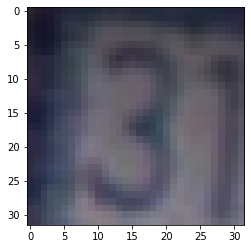

Label:  [3]


In [5]:
#Probando que las imágenes se hayan cargado de manera correcta
plt.imshow(train_images[8])
plt.show()

print('Label: ', train_labels[8])

Se utilizará One-Hot Encoding para representar las categorías (0 al 9)

In [6]:
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

Utilizaremos el set de entrenamiento inicial para crear el split de entrenamiento y validación para el modelo. (85% y 15% respectivamente)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=42)

Con esto confirmamos el número y dimensiones para los conjuntos de entrenamiento y validación.

In [8]:
print(X_train.shape)
print(X_val.shape)

(62268, 32, 32, 3)
(10989, 32, 32, 3)


Para incrementar el dominio de la naturaleza de las imágenes, añadiremos una capa de data augmentation para prevenir overfitting. Cabe destacar que solo se aplica rotación y zoom aleatorios para no cambiar efectivamente la categoría de la imagen. Por ejemplo, no se le pone random flip porque el número dejaría de ser reconocible.

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2)
    ]
)

## Definición del modelo

Se optó por el uso de una CNN tradicional de seis capas principales de convolución. Se utiliza BatchNormalization para establizar el comportamiento durante el entrenamiento. Además, Se utilizan capas de MaxPooling intermedias para realizar downsampling y agilizar el cómputo de predicciones, de igual manera, sirve para atenuar varianzas en la imagen como rotación o el zoom que puede suceder naturalmente. Igualmente, se añaden capas de Dropout para prevenir overfitting. 

Finalmente, los datos procesados son utilizados por una capa de softmax que predice la categoría.

In [10]:
#Se define una función que regresa la arquitectura en limpio cada vez que se llama
def Model1():
    return keras.Sequential([
    data_augmentation,
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(10,  activation='softmax')
])

No se utilizó ninguna técnica en especial para determinar el mejor learning rate (hyperparameter tunning), no obstante se sabe que para las CNN éste tiene que ser particularmente bajo, por lo que se decidió establecerlo como 0.001.

In [11]:
m1 = Model1()
early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=0.001, amsgrad=True)
m1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
m1.summary()

ValueError: ignored

In [13]:
history = m1.fit(X_train, y_train, batch_size=128,
                              epochs=40, validation_data=(X_val, y_val),
                              callbacks=[early_stopping]) 

Epoch 1/40
487/487 [==============================] - 17s 15ms/step - loss: 2.2285 - accuracy: 0.2094 - val_loss: 1.7491 - val_accuracy: 0.3601
Epoch 2/40
487/487 [==============================] - 6s 13ms/step - loss: 1.1380 - accuracy: 0.6218 - val_loss: 0.6548 - val_accuracy: 0.7926
Epoch 3/40
487/487 [==============================] - 7s 13ms/step - loss: 0.7647 - accuracy: 0.7538 - val_loss: 0.5491 - val_accuracy: 0.8267
Epoch 4/40
487/487 [==============================] - 7s 14ms/step - loss: 0.6644 - accuracy: 0.7887 - val_loss: 0.4455 - val_accuracy: 0.8661
Epoch 5/40
487/487 [==============================] - 7s 13ms/step - loss: 0.6148 - accuracy: 0.8045 - val_loss: 0.4458 - val_accuracy: 0.8647
Epoch 6/40
487/487 [==============================] - 7s 14ms/step - loss: 0.5772 - accuracy: 0.8169 - val_loss: 0.4598 - val_accuracy: 0.8589
Epoch 7/40
487/487 [==============================] - 7s 13ms/step - loss: 0.5525 - accuracy: 0.8259 - val_loss: 0.3869 - val_accuracy: 0.880

A continuación se muestra el accuracy del modelo, comparando su desempeño en el set de entrenamiento y validación. En este caso, se observa que ambos tienen pendiente positiva en todo momento. No existe una disparidad sustancial en ambas magnitudes por lo que no se trata de underfitting u overfitting. Cabe destacar que el accuracy de entrenamiento es más estable que el de validación, pero el segundo se mantiene lo suficiente para mantener la tendencia. Inclusive se puede apreciar menos variabilidad en las últimas épocas.

Text(0.5, 1.0, 'Epochs vs. Training and Validation Accuracy')

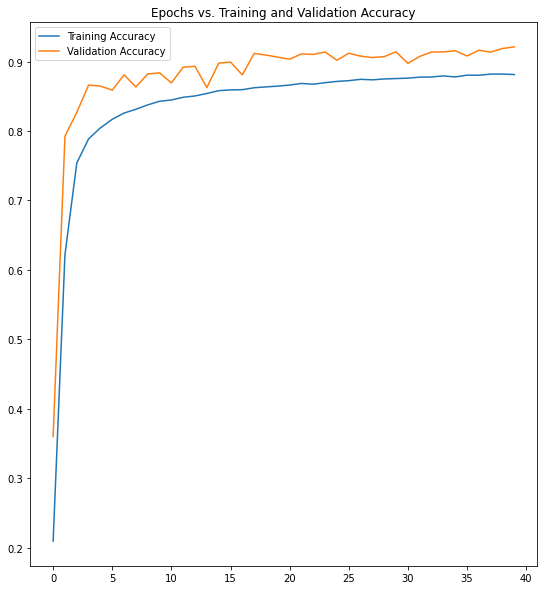

In [14]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')

## Evaluación del modelo

Para apreciar el comportamiento del modelo durante y al final del entrenamiento, se utilizará el KFold cross-validation para analizar su consistencia. Para ello, se determinará el accuracy promedio y su desviación estándar de todas las instancias experimentales. En este caso, tanto un accuracy promedio alto y una desviación estándar baja (qué tan entrenable es) apuntan a un modelo con mejor desempeño.

In [15]:
from sklearn.model_selection import KFold

En contraste a la primera instancia del modelo, cada iteración del KFold se entrenerán solo durante 30 épocas.

In [16]:
#80% train y 20% validation
n_split = 5
k_eval = []

for train_i ,val_i in KFold(n_split).split(train_images):
  x_train,x_val= train_images[train_i], train_images[val_i]
  y_t,y_v= train_labels[train_i], train_labels[val_i]

  aux = Model1()

  aux.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  aux.fit(x_train, y_t,epochs=30)

  eval = aux.evaluate(x_val,y_v)
  k_eval.append(eval[1])

print('Model evaluation ', eval)

Epoch 1/30
1832/1832 [==============================] - 17s 8ms/step - loss: 2.2206 - accuracy: 0.1986
Epoch 2/30
1832/1832 [==============================] - 12s 7ms/step - loss: 1.2058 - accuracy: 0.5970
Epoch 3/30
1832/1832 [==============================] - 12s 7ms/step - loss: 0.8142 - accuracy: 0.7380
Epoch 4/30
1832/1832 [==============================] - 12s 7ms/step - loss: 0.6989 - accuracy: 0.7742
Epoch 5/30
1832/1832 [==============================] - 14s 7ms/step - loss: 0.6481 - accuracy: 0.7937
Epoch 6/30
1832/1832 [==============================] - 12s 7ms/step - loss: 0.6096 - accuracy: 0.8082
Epoch 7/30
1832/1832 [==============================] - 12s 7ms/step - loss: 0.5826 - accuracy: 0.8180
Epoch 8/30
1832/1832 [==============================] - 12s 7ms/step - loss: 0.5590 - accuracy: 0.8249
Epoch 9/30
1832/1832 [==============================] - 12s 7ms/step - loss: 0.5436 - accuracy: 0.8306
Epoch 10/30
1832/1832 [==============================] - 12s 7ms/step - l

Un accuracy de 90 puede ser considerado como plausible dependiendo de la tarea que se le asigne. De igual manera, la razón entre la desviación estándar de la media apuntan a que dicho accuracy posee una estabilidad sustancial (<1%).

In [17]:
result = np.array(k_eval)
print("Mean accuracy: ", result.mean())
print("Standard deviation: ", result.std())

Mean accuracy:  0.909251081943512
Standard deviation:  0.004986134754204118


Se muestan los resultados sobre el set de prueba provisto por el dataset. Es notable que tuvo un accuracy sustancialmente más alto que el promedio del KFold. Esto puede deberse a la capa de data augmentation que altera las imágenes para prevenir overfitting sobre el set de entrenamiento, pero que resulta benéfico para su desempeño en datos no vistos previamente.

In [18]:
test_loss, test_acc = m1.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9303 
Test loss is: 0.2499


# Segundo modelo (posibles mejoras)

### Hacer la red más profunda

El primer modelo consta de 6 capas de convolusión, 3 con un tamaño de output de 32 y 3 de tamaño de 64. Entonces, una primera propuesta es hacer la red más profunda agregando otras tres capas de convolusión con tamaño de output mayor (128), para que se mantenga la complejidad de las capas intermedias. (densidad de output intermedio). Esto implica tener más parámetros para interpretar diferencias más sutiles.

### Agregar skip connections

Al hacer la red más profunda nos podemos encontrar con problemas de variabilidad no deseada en el gradiente de la función de costo (shattered gradient), por lo que conexiones residuales pueden ayudar a aminorar este fenómeno.

### Agregar una capa densa al final

Aunque es posible que una red densa provoque overfitting al aprender las características proporcionadas por las CNN, podría ser útil para mejorar el accuracy un poco más en caso de que la CNN por sí sola no alcance resultados deseados.

### Alinear Max-Pooling con la red que incrementa el número de kernels

Aunque el beneficio no sea asegurado, se puede interpretar como la multiplicación del número de celdas que un kernel "ve" en cada uno de los inputs y el número de kernel per se. Si se mantiene el número de kernels después de un Max Pooling, dichos kernels verán una simplificación de los inputs anteriores y probablemente carezcan de información valiosa, y esto se propagará a las capas siguientes. Esto asume que la información perdida por el Max Pooling en efecto es significativa, pero se sigue tomando las ventajas del pooling aplicándolo en un momento más oportuno.


In [10]:
def M2():    
    input = keras.Input(shape=(32, 32, 3))

    data_augmentation = keras.Sequential(
        [
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.2),
        ]
    )

    x = data_augmentation(input)

    x = layers.Rescaling(1./255)(x)

    for size in [32, 64, 128]:
        residual = x
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
        x = layers.Activation("relu")(x)

        x = layers.Dropout(0.3)(x)
        x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
        x = layers.Activation("relu")(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(0.3)(x)
        

        residual = layers.Conv2D(
            size, 1, strides=2, padding="same", use_bias=False)(residual)

        x = layers.add([x, residual])

    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    model2 = keras.Model(inputs=input, outputs=outputs)
    return model2

model2 = M2()

Al tratarse de una red algo más profunda, se reducirá un poco el learning rate respecto al anterior para aminorar un posible fenómento de exploding gradient.

In [11]:
early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=.0008, amsgrad=True)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
history2 = model2.fit(X_train, y_train, batch_size=128, 
                      epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
487/487 [==============================] - 13s 26ms/step - loss: 2.1549 - accuracy: 0.2266 - val_loss: 1.3844 - val_accuracy: 0.5507
Epoch 2/40
487/487 [==============================] - 12s 25ms/step - loss: 1.0326 - accuracy: 0.6600 - val_loss: 0.5862 - val_accuracy: 0.8145
Epoch 3/40
487/487 [==============================] - 12s 25ms/step - loss: 0.6635 - accuracy: 0.7868 - val_loss: 0.4313 - val_accuracy: 0.8692
Epoch 4/40
487/487 [==============================] - 15s 30ms/step - loss: 0.5475 - accuracy: 0.8281 - val_loss: 0.4215 - val_accuracy: 0.8702
Epoch 5/40
487/487 [==============================] - 12s 25ms/step - loss: 0.4951 - accuracy: 0.8437 - val_loss: 0.3382 - val_accuracy: 0.8990
Epoch 6/40
487/487 [==============================] - 13s 26ms/step - loss: 0.4597 - accuracy: 0.8559 - val_loss: 0.3207 - val_accuracy: 0.9051
Epoch 7/40
487/487 [==============================] - 14s 28ms/step - loss: 0.4270 - accuracy: 0.8668 - val_loss: 0.3136 - val_accuracy:

No se observa underfitting u overfitting al igual que en el primer modelo (no se separan las líneas). No obstante, los valores de accuracy tanto de entrenamiento como validación son superiores. Incluso la separación entre éstas es menor. Esto indica un "fit" superior. Además, el accuracy de validación se estabiliza más rápido que en la primera arquitectura.

Text(0.5, 1.0, 'Epochs vs. Training and Validation Accuracy')

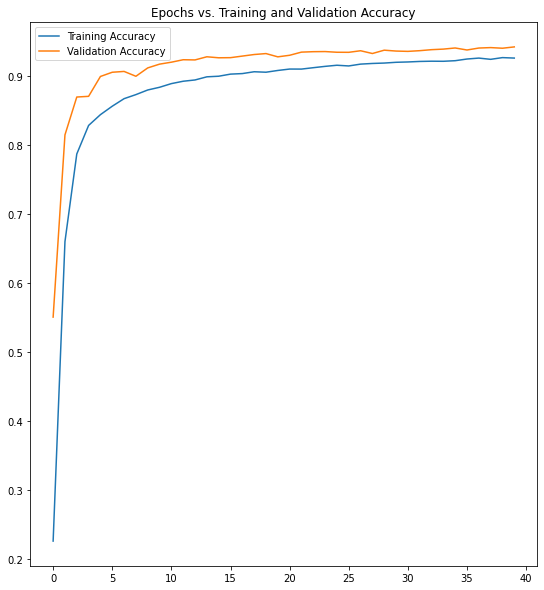

In [16]:
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')

## Evaluación

Se procederá a realizar la mismo procedimiento de KFold cross-validation que el modelo anterior. (k=5)

In [23]:
n_split = 5
k_eval = []

for train_i ,val_i in KFold(n_split).split(train_images):
  x_train,x_val= train_images[train_i], train_images[val_i]
  y_t,y_v= train_labels[train_i], train_labels[val_i]

  aux = M2()

  aux.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  aux.fit(x_train, y_t,epochs=30)

  eval = aux.evaluate(x_val,y_v)
  k_eval.append(eval[1])

print('Model evaluation ', eval)

Epoch 1/30
1832/1832 [==============================] - 20s 10ms/step - loss: 2.0819 - accuracy: 0.3306
Epoch 2/30
1832/1832 [==============================] - 18s 10ms/step - loss: 1.0439 - accuracy: 0.6600
Epoch 3/30
1832/1832 [==============================] - 18s 10ms/step - loss: 0.7649 - accuracy: 0.7538
Epoch 4/30
1832/1832 [==============================] - 20s 11ms/step - loss: 0.6432 - accuracy: 0.7933
Epoch 5/30
1832/1832 [==============================] - 18s 10ms/step - loss: 0.5639 - accuracy: 0.8217
Epoch 6/30
1832/1832 [==============================] - 18s 10ms/step - loss: 0.5108 - accuracy: 0.8393
Epoch 7/30
1832/1832 [==============================] - 18s 10ms/step - loss: 0.4769 - accuracy: 0.8500
Epoch 8/30
1832/1832 [==============================] - 18s 10ms/step - loss: 0.4507 - accuracy: 0.8590
Epoch 9/30
1832/1832 [==============================] - 18s 10ms/step - loss: 0.4193 - accuracy: 0.8687
Epoch 10/30
1832/1832 [==============================] - 18s 10m

El modelo que implementa las sugerencias presentó un incremento de .03 apróximadamente y mantuvo una relación con la desviación estándar similar al primer modelo (<1%). Esto es una mejora significativa.

In [24]:
result = np.array(k_eval)
print("Mean accuracy: ", result.mean())
print("Standard deviation: ", result.std())

Mean accuracy:  0.9315151572227478
Standard deviation:  0.00373798836209485


Finalmente se muestra el desempeño de la versión entrenada por 40 épocas sobre el set de prueba. El accuracy incrementó .015 aproximadamente , aunque no fue la misma magnitud incremental que en los set de validación, aún fue una mejora significativa. Se tendría también que evaluar ambos modelos al entrenarse en todavía más épocas para conocer su convergencia.

In [25]:
test_loss, test_acc = model2.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9446 
Test loss is: 0.1997
